In [1]:
import math
import glob
import os
import re
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import poppy as pp
from astropy.io import fits
from astropy.modeling.models import BlackBody
import astropy.units as u
import organized_functions as pr

%load_ext autoreload # reload 'autoreload'
%autoreload 2 # autonomously reload all import modules
%matplotlib inline # directly show images in the notebook


C:\Users\yiyan\.conda\envs\phase_retrieval_LFAST\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


ModuleNotFoundError: No module named "autoreload # reload 'autoreload'"

# Read phase diversity data

[-400, -360, -320, -280, -240, -200, -160, -120, -80, -40, 0, 40, 80, 120, 160, 200, 240, 280, 320, 360, 400]
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\-400.fits
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\-360.fits
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\-320.fits
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\-280.fits
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\-240.fits
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\-200.fits
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\-160.fits
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\-120.fits
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\-80.fits
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\-40.fits
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\0.fits
C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity\+40.fits
C:/Users/yiyan/OneDrive/Desktop/

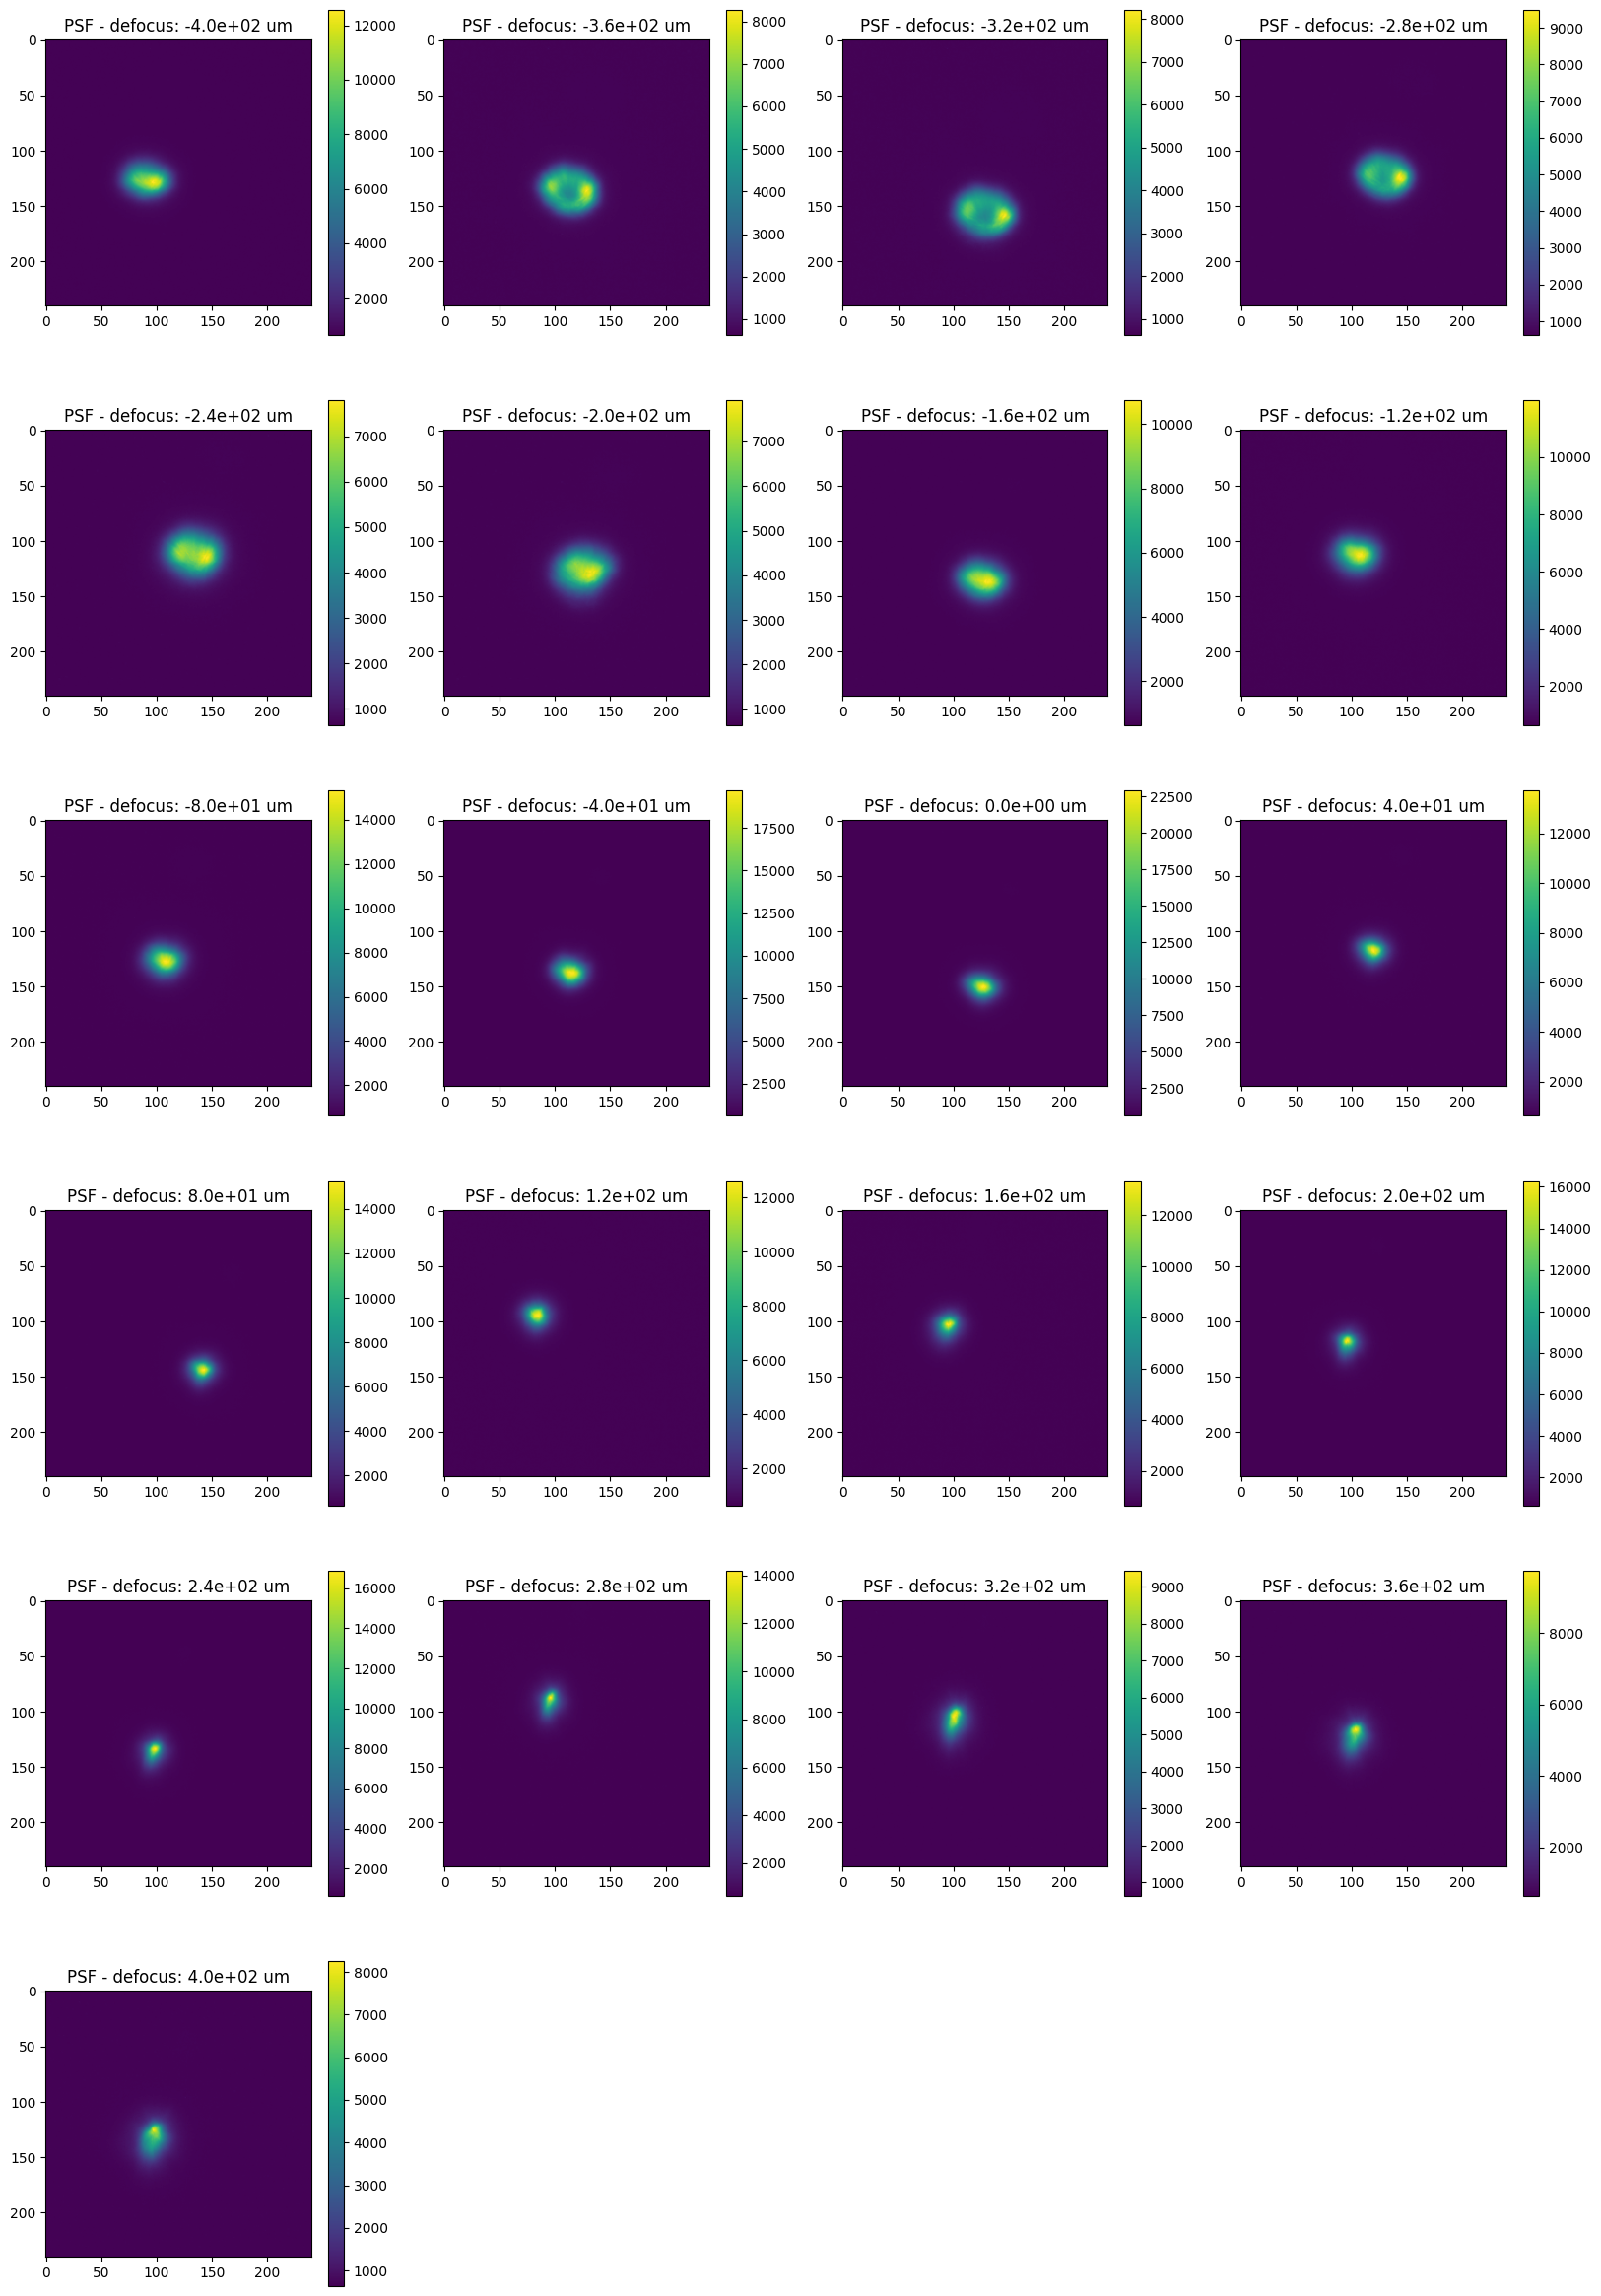

In [2]:
folder_path_pd = 'C:/Users/yiyan/OneDrive/Desktop/data/20250508/phase_diversity'
fits_files_pd = glob.glob(os.path.join(folder_path_pd, '*.fits'))

# Sort files
def extract_number(fpath):
    filename = os.path.basename(fpath)
    match = re.search(r'([-+]?\d+)', filename)
    return int(match.group()) if match else 0
fits_files_pd = sorted(fits_files_pd, key=extract_number)
file_labels = [extract_number(f) for f in fits_files_pd]
print(file_labels)

# Get the shape of the numpy array in 'fits' file
with fits.open(fits_files_pd[0]) as hdul:
    ref_shape = hdul[0].data.shape

# Initialize the numpy array used to save 'fits' data
c = len(fits_files_pd)
M, N = ref_shape
defocus_intensities = np.zeros((c, M, N), dtype=np.float32)

# Read all data
for i, file_path in enumerate(fits_files_pd):
    print(file_path)
    with fits.open(file_path) as hdul:
        defocus_intensities[i] = hdul[0].data
print(defocus_intensities.shape)

# Crop the images
crop_size = min(M,N)
x_start = M // 2 - crop_size // 2
x_end = x_start + crop_size
y_start = N // 2 - crop_size // 2
y_end = y_start + crop_size
defocus_intensities = cp.array(defocus_intensities[:, x_start:x_end, y_start:y_end])
print(defocus_intensities.shape)

# Show all images
image_size = 5
col_num = 4 # column number of images for display
row_num = math.ceil(c / col_num) # row number of images for display
plt.figure(figsize=(image_size * col_num, image_size * row_num))
for i in range(c):
    position_info = file_labels[i] # defocus distance
    plt.subplot(row_num, col_num, i+1)
    plt.imshow(defocus_intensities[i].get())
    plt.title(f'PSF - defocus: {position_info:.1e} um')
    plt.colorbar()
plt.show()


# Generate spectrum

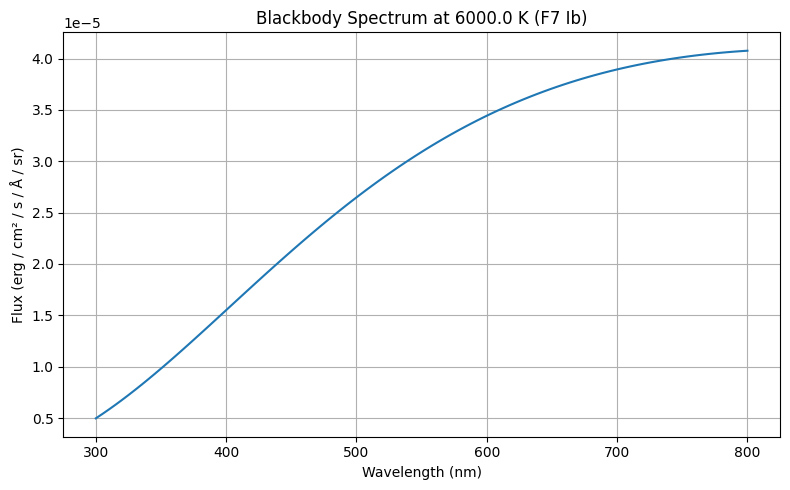

In [5]:
# Temperature of the star
temperature = 6000 * u.K

# Create the spectrum according to its temperature
bb = BlackBody(temperature=temperature)
wavelength = np.linspace(300, 800, 100) * u.nm
flux = bb(wavelength)

# Visualize the spectrum
plt.figure(figsize=(8,5))
plt.plot(wavelength.value, flux.value)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux (erg / cm² / s / Å / sr)')
plt.title(f'Blackbody Spectrum at {temperature.value} K (F7 Ib)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Generate the pupil image

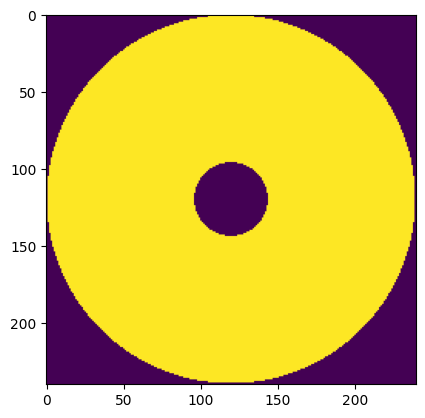

In [6]:
od_pupil = 0.3808 # outer pupil diameter in meters
id_pupil = 0.0762 # inner pupil diameter in meters
npix_pupil = crop_size # sampling rate on a single side of the pupil

x = cp.linspace(-od_pupil / 2, od_pupil / 2, npix_pupil) # give a 1 x 512 vector in range [-d_pupil/2, d_pupil/2]
x, y = cp.meshgrid(x, x) # use 2 vectors to generate 2 mesh grids
r = cp.sqrt(x ** 2 + y ** 2) # radius

pupil = cp.ones_like(r) # create a matrix whose size and data format are similar to 'r' and value is 1
pupil[r >= od_pupil / 2] = 0 # update the pupil according to the positions obtained through 'r'
pupil[r <= id_pupil / 2] = 0

plt.imshow(pupil.get())
plt.show()


# Get defocus probes

[3.00000000e-07 3.05050505e-07 3.10101010e-07 3.15151515e-07
 3.20202020e-07 3.25252525e-07 3.30303030e-07 3.35353535e-07
 3.40404040e-07 3.45454545e-07 3.50505051e-07 3.55555556e-07
 3.60606061e-07 3.65656566e-07 3.70707071e-07 3.75757576e-07
 3.80808081e-07 3.85858586e-07 3.90909091e-07 3.95959596e-07
 4.01010101e-07 4.06060606e-07 4.11111111e-07 4.16161616e-07
 4.21212121e-07 4.26262626e-07 4.31313131e-07 4.36363636e-07
 4.41414141e-07 4.46464646e-07 4.51515152e-07 4.56565657e-07
 4.61616162e-07 4.66666667e-07 4.71717172e-07 4.76767677e-07
 4.81818182e-07 4.86868687e-07 4.91919192e-07 4.96969697e-07
 5.02020202e-07 5.07070707e-07 5.12121212e-07 5.17171717e-07
 5.22222222e-07 5.27272727e-07 5.32323232e-07 5.37373737e-07
 5.42424242e-07 5.47474747e-07 5.52525253e-07 5.57575758e-07
 5.62626263e-07 5.67676768e-07 5.72727273e-07 5.77777778e-07
 5.82828283e-07 5.87878788e-07 5.92929293e-07 5.97979798e-07
 6.03030303e-07 6.08080808e-07 6.13131313e-07 6.18181818e-07
 6.23232323e-07 6.282828

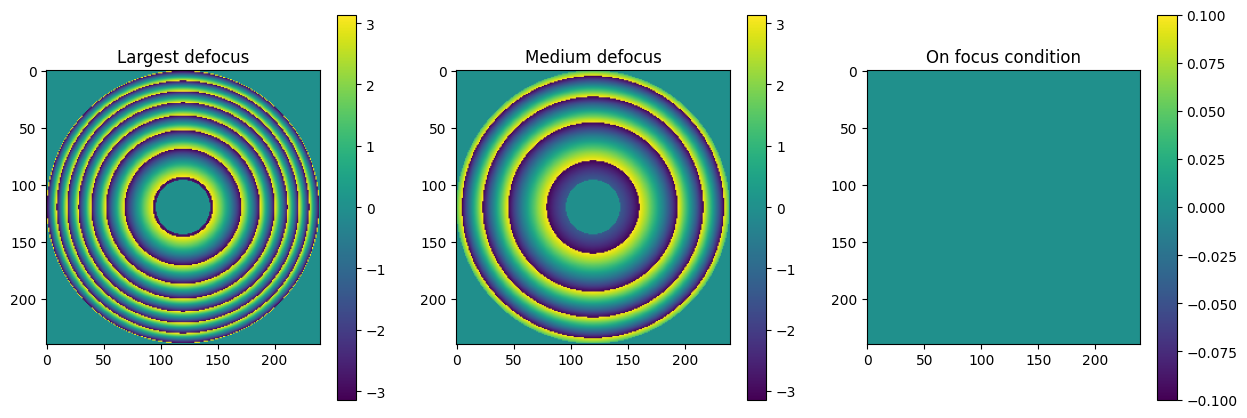

In [11]:
focal_length = 2.537 # focal length in meters
position = cp.array(file_labels) # defocus distances in microns
position = position * 1e-6 # in meters

wavelengths = cp.array(wavelength.value * 1e-9) # wavelength in meter
print(wavelengths)
broadband_probes = [] # initialize a list to store probes for different wavelengths
for wl in wavelengths:
    defocus_values = position/ (8 * wl * (focal_length / od_pupil) ** 2)  # defocus distance is calculated from L = 8Qλ(f/D)^2, so the defocus wave number can be inversely calculated through this
    probes = pr.get_defocus_probes(pupil, defocus_values)
    broadband_probes.append(probes)
broadband_probes = np.stack(broadband_probes, axis=0)
print(broadband_probes.shape) # get the shape of the broad band probes

wave_number = broadband_probes.shape[0] # wavelength layer
print(wave_number)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.angle(broadband_probes[49, 0]).get())
plt.colorbar()
plt.title('Largest defocus')
plt.subplot(1, 3, 2)
plt.imshow(np.angle(broadband_probes[49, 5]).get())
plt.colorbar()
plt.title('Medium defocus')
plt.subplot(1, 3, 3)
plt.imshow(np.angle(broadband_probes[49, 10]).get())
plt.colorbar()
plt.title('On focus condition')
plt.show()


# Do phase retrieval


Imeas type: <class 'cupy.ndarray'>
fitmask type: <class 'cupy.ndarray'>
Eprobes type: <class 'cupy.ndarray'>
modes type: <class 'cupy.ndarray'>
<class 'cupy.ndarray'>


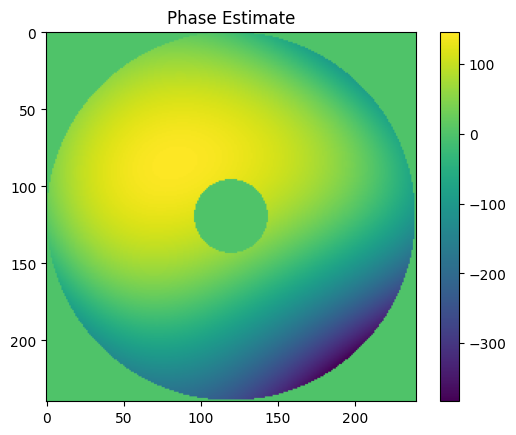

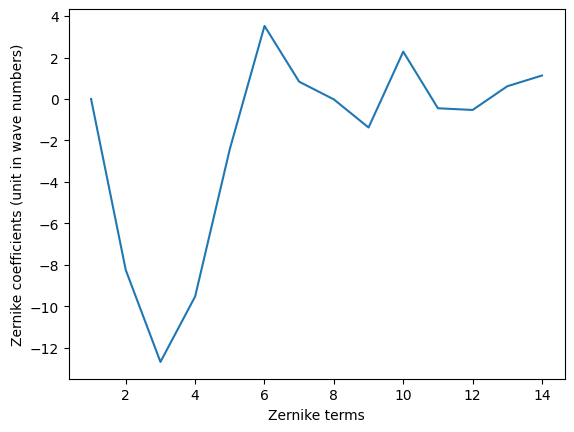

In [13]:
coeff_num = 14
zernikes = pp.zernike.arbitrary_basis(pupil, nterms=coeff_num, outside=0) # give the bases of 45 zernike polynomials
single_probe = broadband_probes[49] # the defocus probe of the chosen wavelength
print("Imeas type:", type(defocus_intensities))
print("fitmask type:", type(pupil))
print("Eprobes type:", type(probes))
print("modes type:", type(zernikes))

phase_retrieval_dict = pr.run_phase_retrieval(Imeas=defocus_intensities, fitmask=pupil, Eprobes=single_probe, modes=zernikes, tol=1e-8, reg=0, wreg=1e3, fit_amp=False)
print(type(phase_retrieval_dict['fit_params']))
estimated_coeffs = phase_retrieval_dict['fit_params'] # returns in units of radians

np_phase = phase_retrieval_dict['phase_est'].get()
# np.save('phase_estimate.npy', np_phase)
plt.imshow(phase_retrieval_dict['phase_est'].get())
plt.colorbar()
plt.title('Phase Estimate')
# plt.savefig('Phase Estimate.png')
plt.show()

hori_axis = np.linspace(1, coeff_num, coeff_num, dtype=int)
estimate_coeffs = cp.asnumpy(estimated_coeffs[:coeff_num]) / (2 * cp.pi)

plt.plot(hori_axis, estimate_coeffs)
plt.xlabel('Zernike terms')
plt.ylabel('Zernike coefficients (unit in wave numbers)')
plt.show()
